<a href="https://colab.research.google.com/github/AndreaCastiella/Sequences-Time-Series-and-Prediction/blob/main/S%2BP_Week_3_Lesson_4_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tf-nightly-2.0-preview


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 8s 29ms/step - loss: 21.9679 - mae: 22.4630
Epoch 2/100
31/31 [==============================] - 1s 26ms/step - loss: 21.0787 - mae: 21.5699
Epoch 3/100
31/31 [==============================] - 1s 26ms/step - loss: 19.9720 - mae: 20.4666
Epoch 4/100
31/31 [==============================] - 1s 27ms/step - loss: 20.5891 - mae: 21.0813
Epoch 5/100
31/31 [==============================] - 1s 26ms/step - loss: 20.2777 - mae: 20.7735
Epoch 6/100
31/31 [==============================] - 1s 27ms/step - loss: 19.6437 - mae: 20.1366
Epoch 7/100
31/31 [==============================] - 1s 26ms/step - loss: 18.2940 - mae: 18.7848
Epoch 8/100
31/31 [==============================] - 1s 26ms/step - loss: 17.2657 - mae: 17.7576
Epoch 9/100
31/31 [==============================] - 1s 27ms/step - loss: 17.4906 - mae: 17.9840
Epoch 10/100
31/31 [==============================] - 1s 27ms/step - loss: 16.8689 - mae: 17.3590
Epoch 11/100
31/31 [=========

(1e-08, 0.0001, 0.0, 30.0)

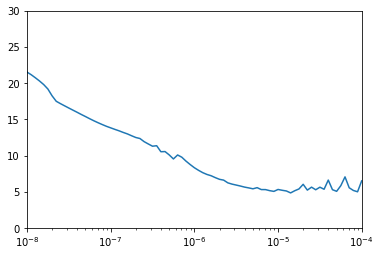

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500
31/31 [==============================] - 8s 26ms/step - loss: 1318.5851 - mae: 29.4738
Epoch 2/500
31/31 [==============================] - 1s 26ms/step - loss: 137.4052 - mae: 8.9372
Epoch 3/500
31/31 [==============================] - 1s 28ms/step - loss: 97.3382 - mae: 7.5399
Epoch 4/500
31/31 [==============================] - 1s 26ms/step - loss: 121.3010 - mae: 8.2451
Epoch 5/500
31/31 [==============================] - 1s 28ms/step - loss: 97.0395 - mae: 7.4623
Epoch 6/500
31/31 [==============================] - 1s 27ms/step - loss: 173.7082 - mae: 10.7596
Epoch 7/500
31/31 [==============================] - 1s 28ms/step - loss: 116.7360 - mae: 8.3986
Epoch 8/500
31/31 [==============================] - 1s 27ms/step - loss: 81.8512 - mae: 6.7184
Epoch 9/500
31/31 [==============================] - 1s 26ms/step - loss: 84.1435 - mae: 6.9853
Epoch 10/500
31/31 [==============================] - 1s 27ms/step - loss: 64.0831 - mae: 6.3467
Epoch 11/500
31/31 [===========

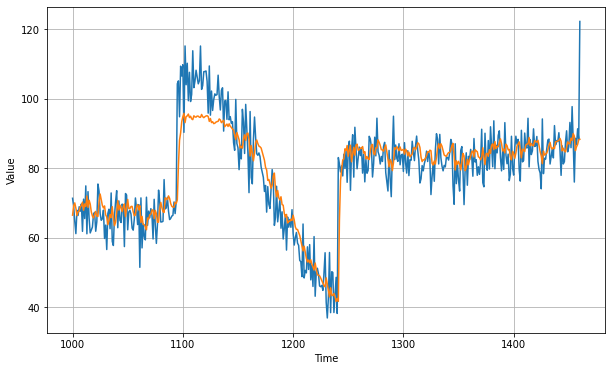

In [10]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [11]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.366846

<Figure size 432x288 with 0 Axes>

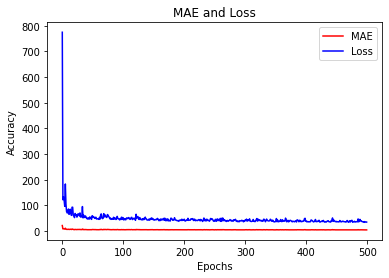

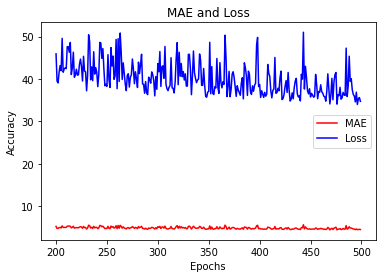

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [15]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100, verbose=1)

Epoch 1/100
31/31 [==============================] - 8s 27ms/step - loss: 197.0923
Epoch 2/100
31/31 [==============================] - 1s 27ms/step - loss: 86.9145
Epoch 3/100
31/31 [==============================] - 1s 27ms/step - loss: 85.9377
Epoch 4/100
31/31 [==============================] - 1s 27ms/step - loss: 66.0037
Epoch 5/100
31/31 [==============================] - 1s 28ms/step - loss: 63.4535
Epoch 6/100
31/31 [==============================] - 1s 29ms/step - loss: 59.9289
Epoch 7/100
31/31 [==============================] - 1s 27ms/step - loss: 63.6053
Epoch 8/100
31/31 [==============================] - 1s 26ms/step - loss: 53.8102
Epoch 9/100
31/31 [==============================] - 1s 26ms/step - loss: 48.7229
Epoch 10/100
31/31 [==============================] - 1s 27ms/step - loss: 47.8366
Epoch 11/100
31/31 [==============================] - 1s 26ms/step - loss: 47.1367
Epoch 12/100
31/31 [==============================] - 1s 26ms/step - loss: 51.6676
Epoch 13/100

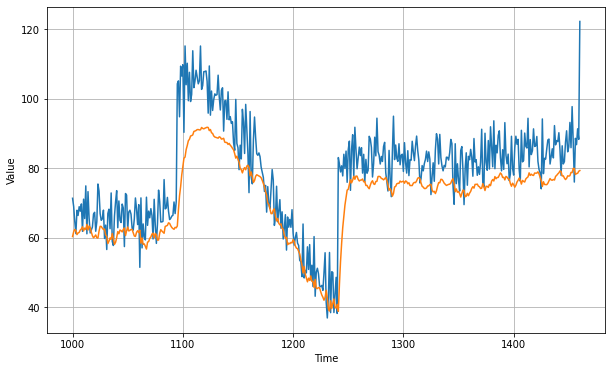

In [18]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [19]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100, verbose=1)

Epoch 1/100
31/31 [==============================] - 11s 41ms/step - loss: 1673.7275
Epoch 2/100
31/31 [==============================] - 1s 38ms/step - loss: 161.4229
Epoch 3/100
31/31 [==============================] - 1s 38ms/step - loss: 99.7858
Epoch 4/100
31/31 [==============================] - 1s 40ms/step - loss: 64.5485
Epoch 5/100
31/31 [==============================] - 1s 40ms/step - loss: 71.8685
Epoch 6/100
31/31 [==============================] - 1s 39ms/step - loss: 70.1862
Epoch 7/100
31/31 [==============================] - 1s 41ms/step - loss: 63.3256
Epoch 8/100
31/31 [==============================] - 1s 39ms/step - loss: 62.5841
Epoch 9/100
31/31 [==============================] - 1s 39ms/step - loss: 72.5294
Epoch 10/100
31/31 [==============================] - 1s 39ms/step - loss: 59.8723
Epoch 11/100
31/31 [==============================] - 1s 38ms/step - loss: 60.5314
Epoch 12/100
31/31 [==============================] - 1s 39ms/step - loss: 59.4842
Epoch 13/

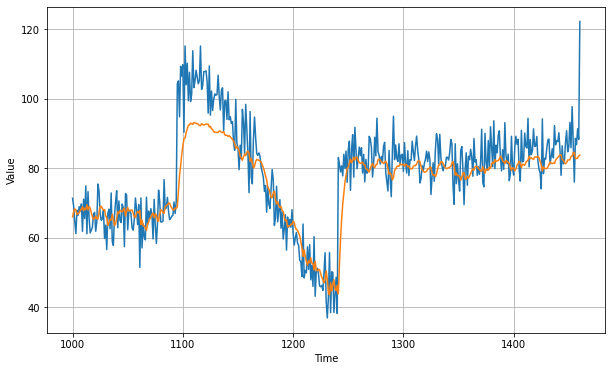

In [20]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)